In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, RepeatVector, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model


df = pd.read_csv('Raw Database.csv')
df['Description'] = df['Description'].str.strip()
df = df[~df['InvoiceNo'].str.contains('C')]
df = df[~df['StockCode'].str.contains('POST')]

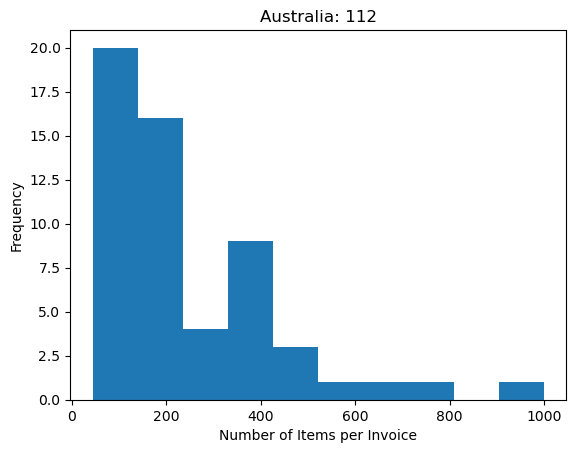

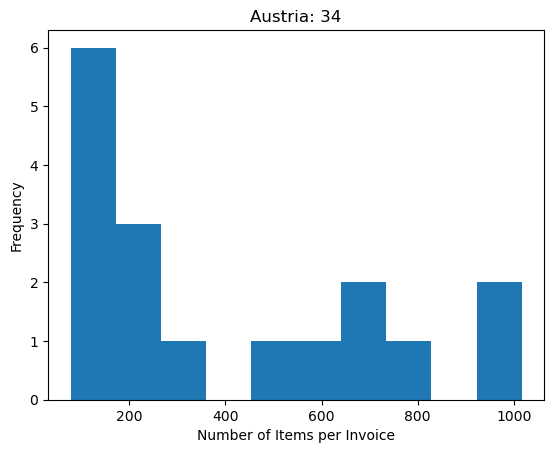

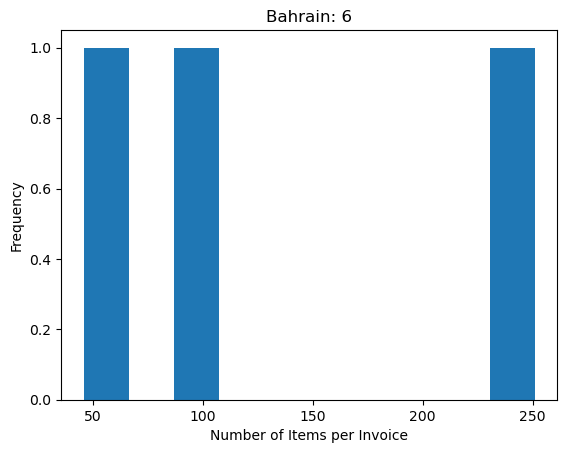

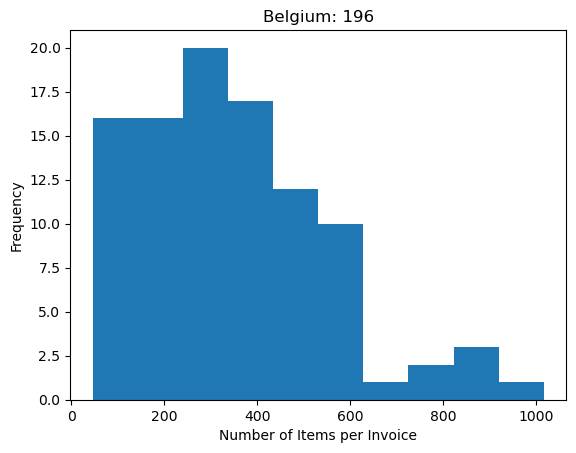

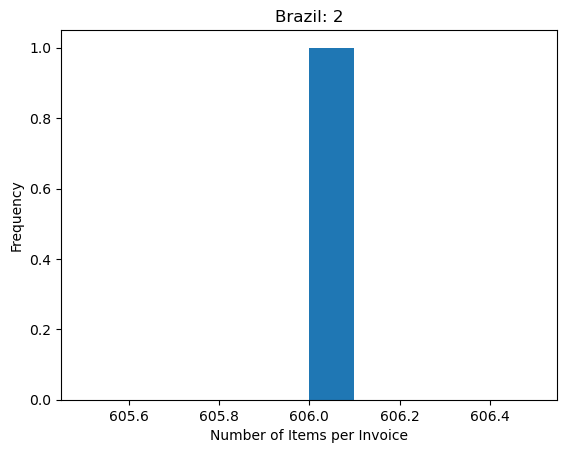

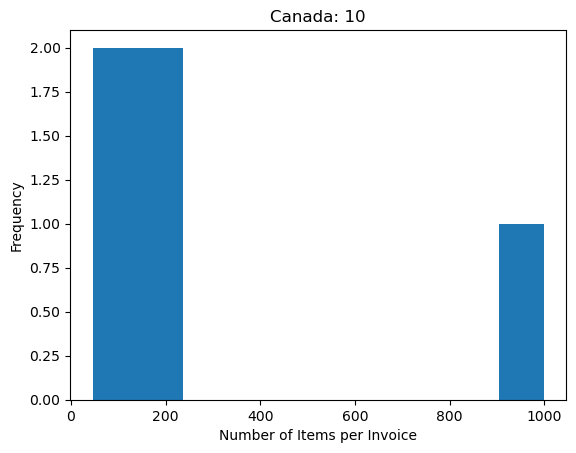

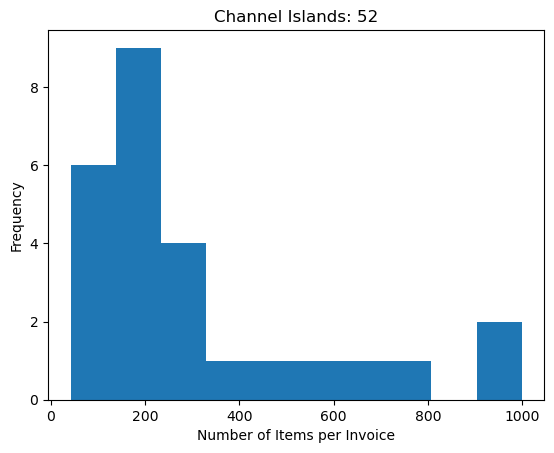

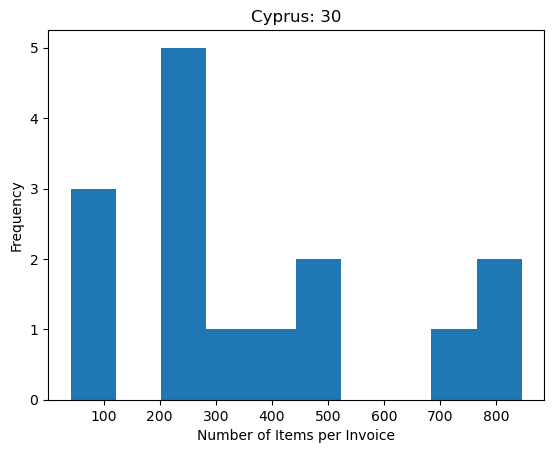

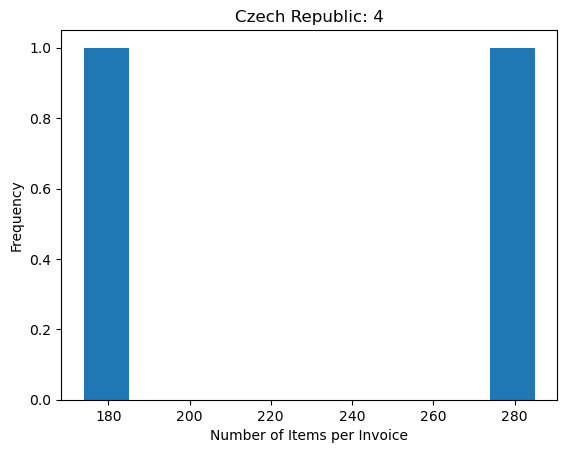

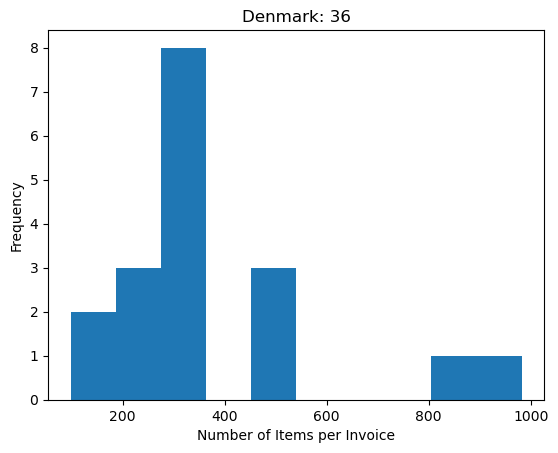

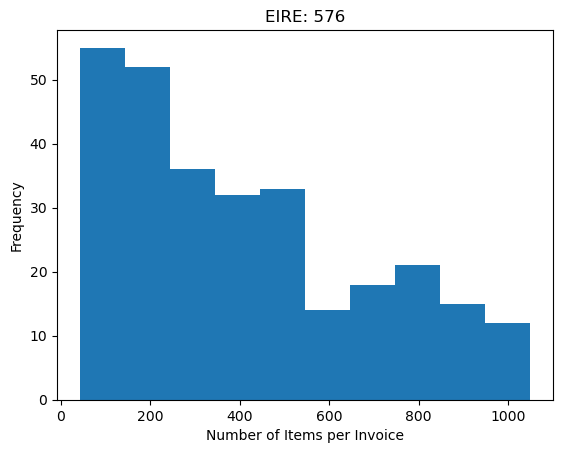

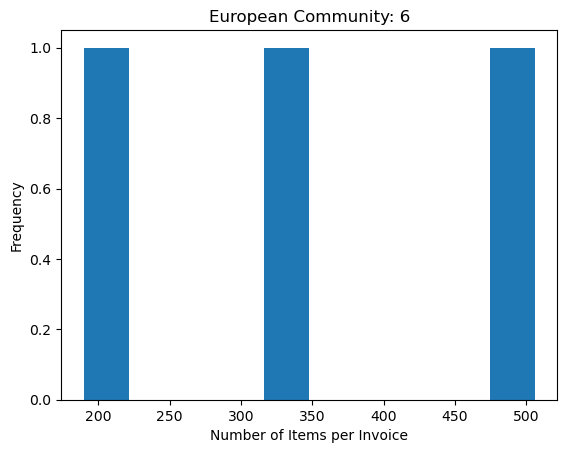

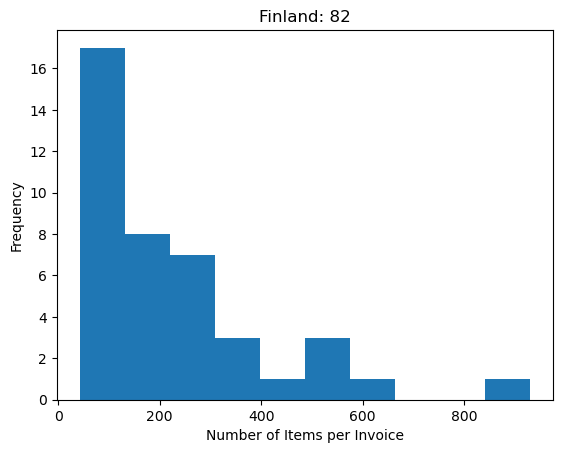

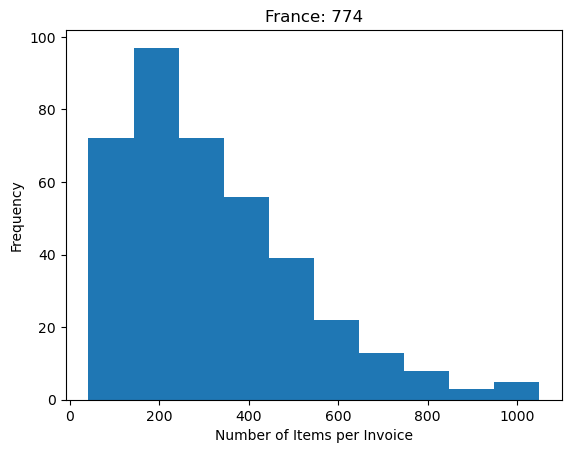

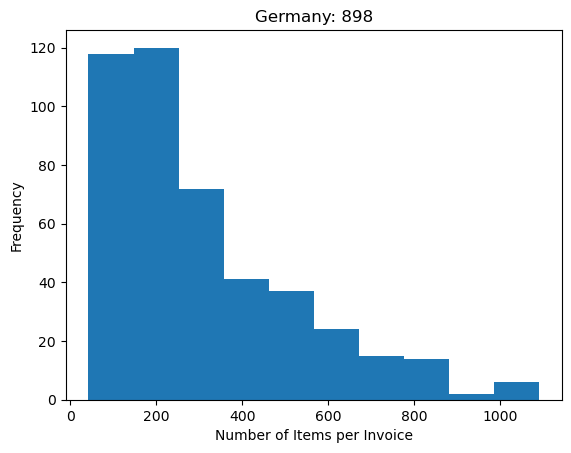

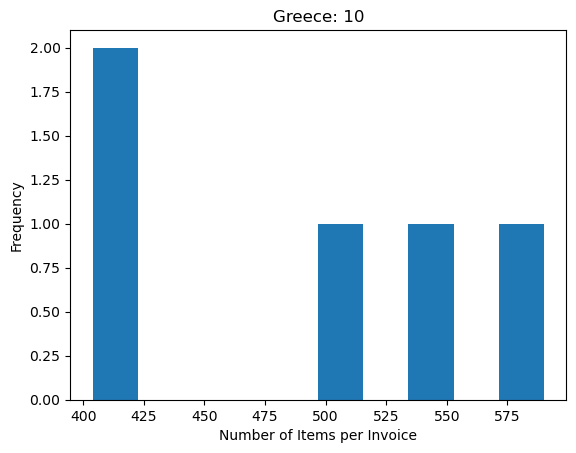

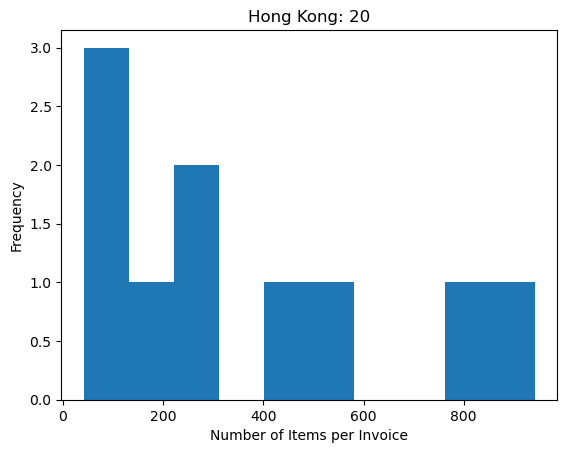

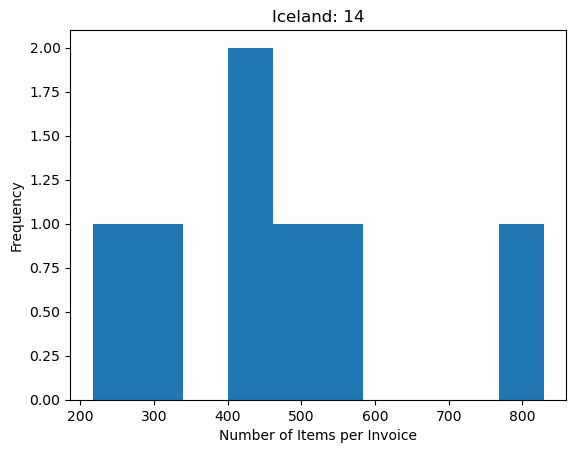

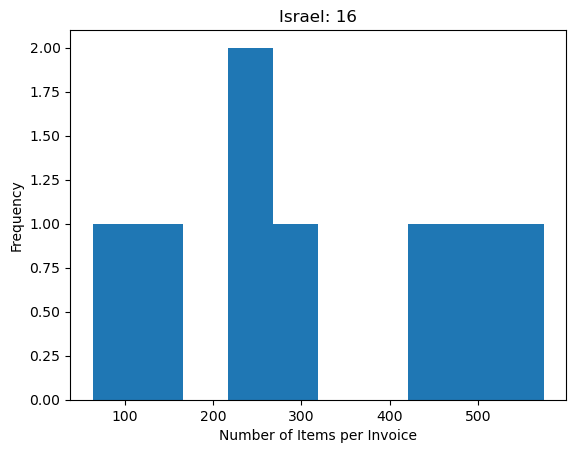

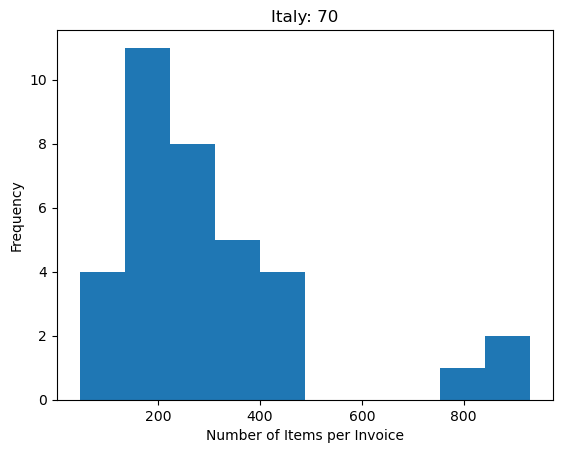

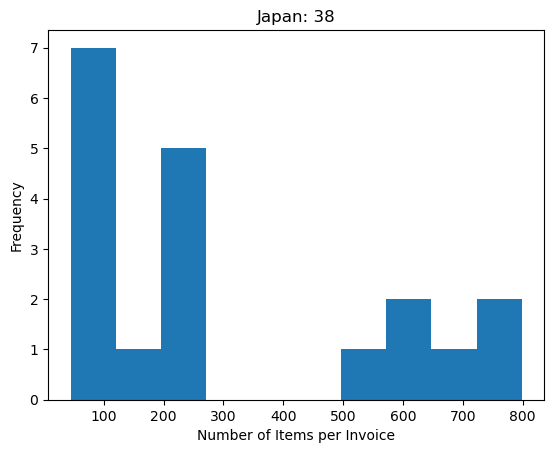

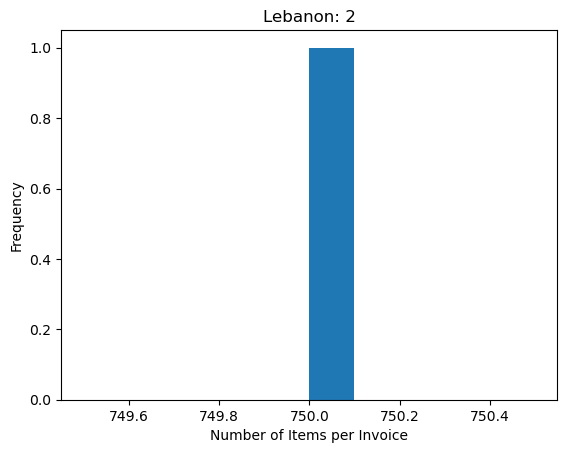

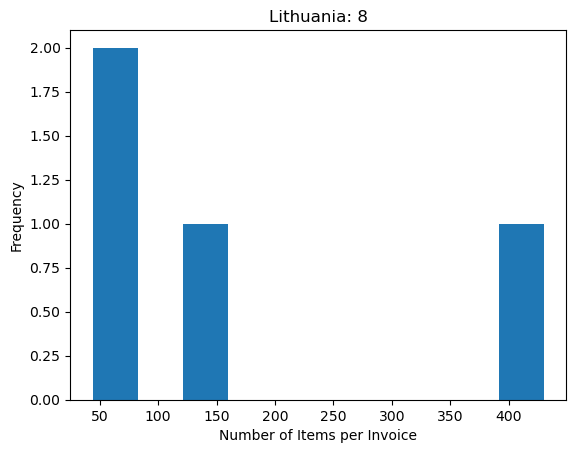

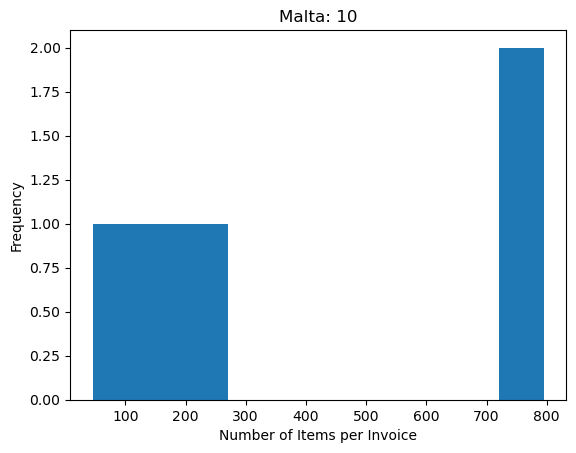

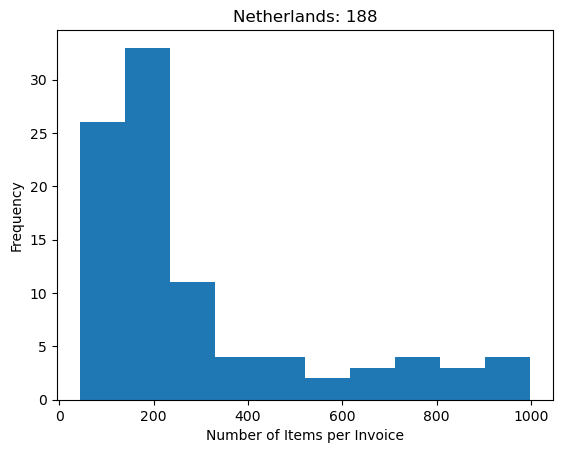

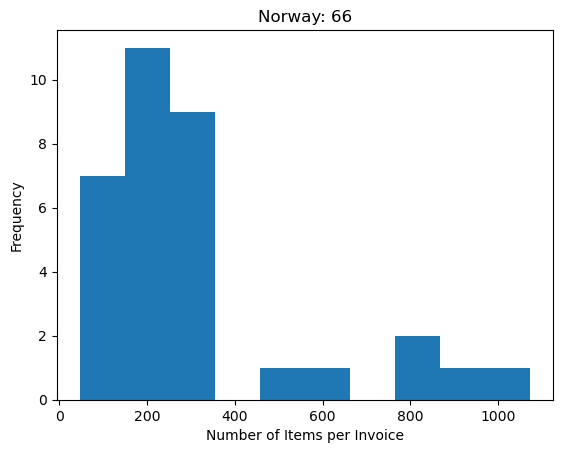

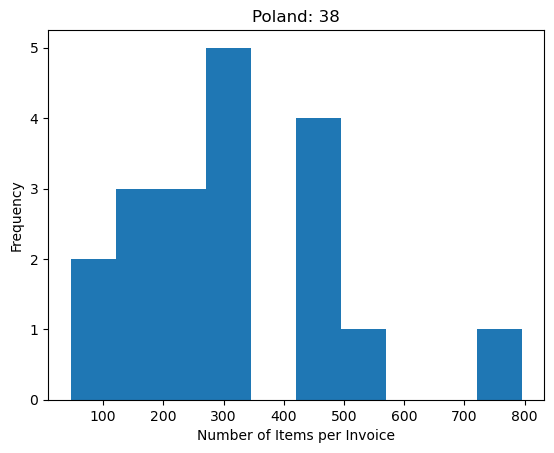

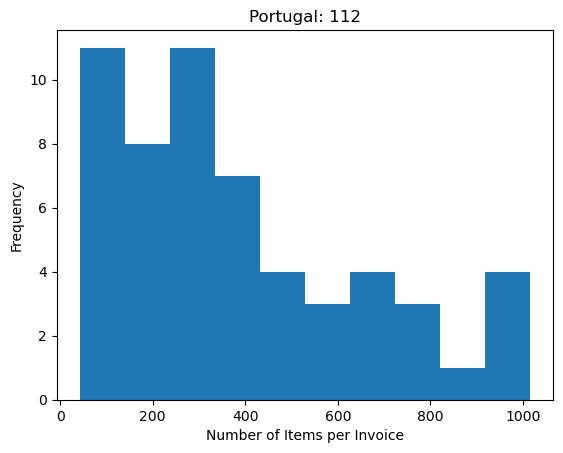

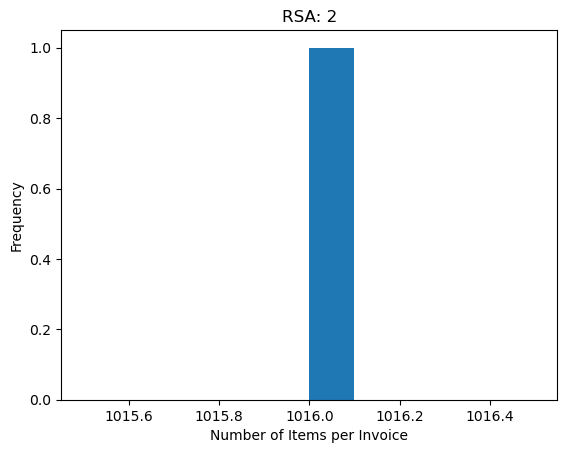

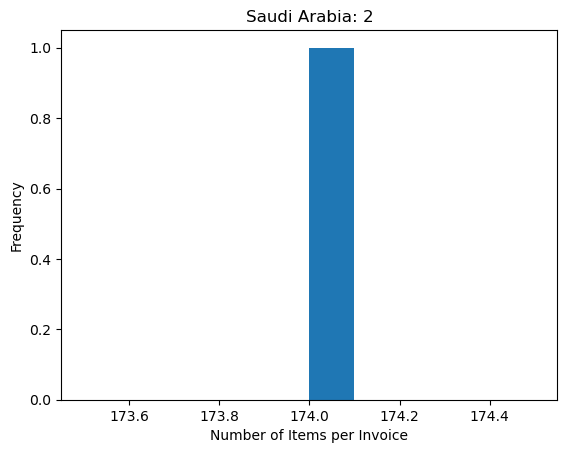

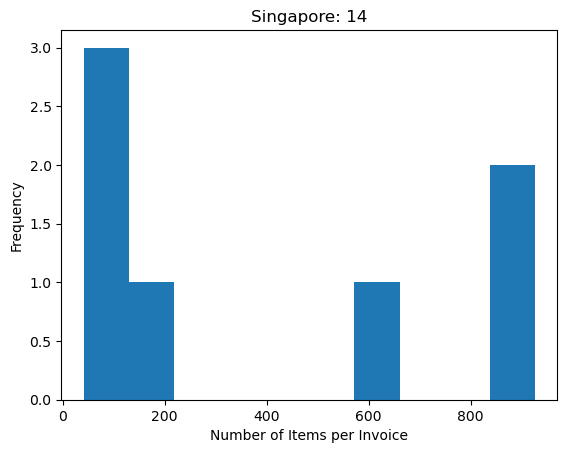

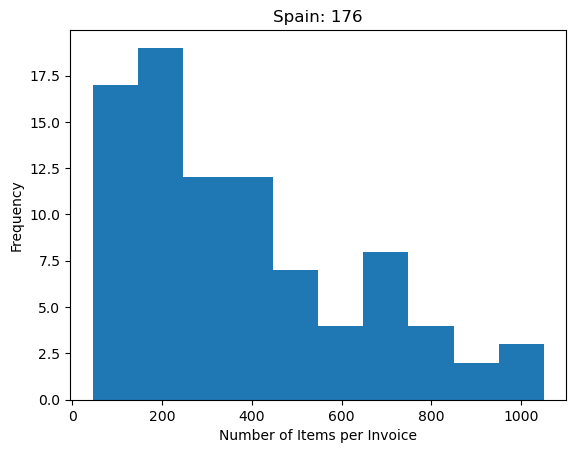

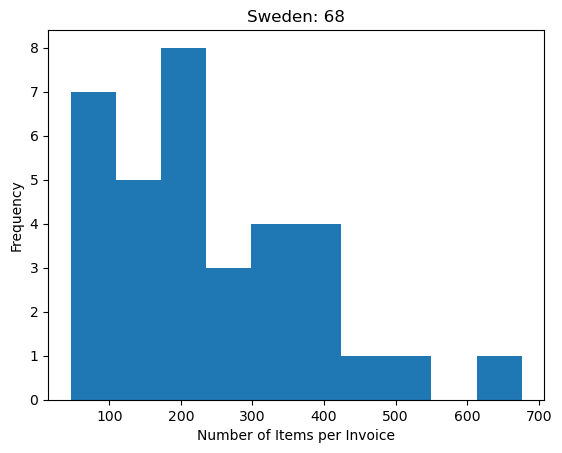

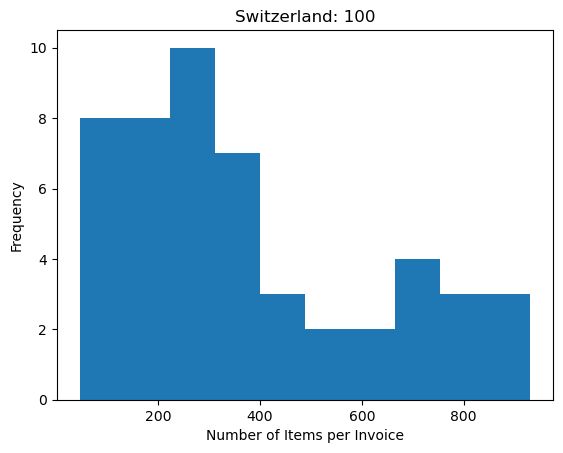

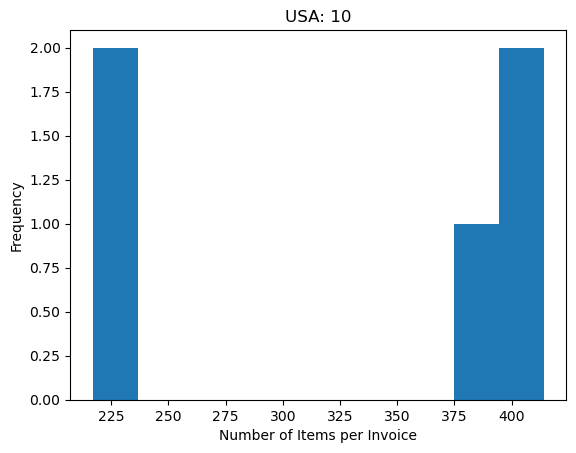

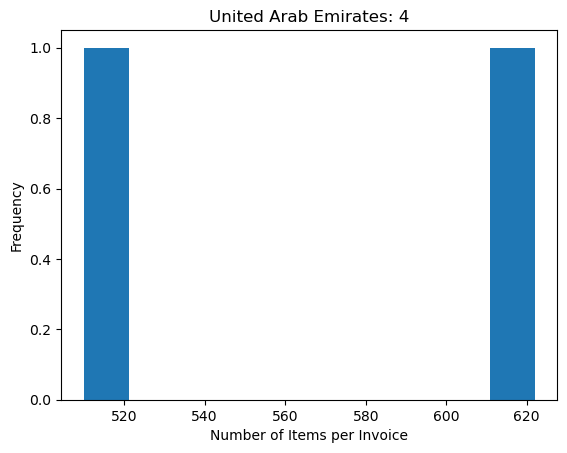

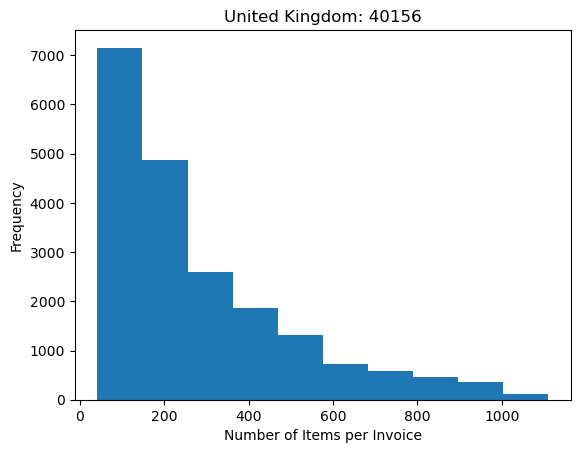

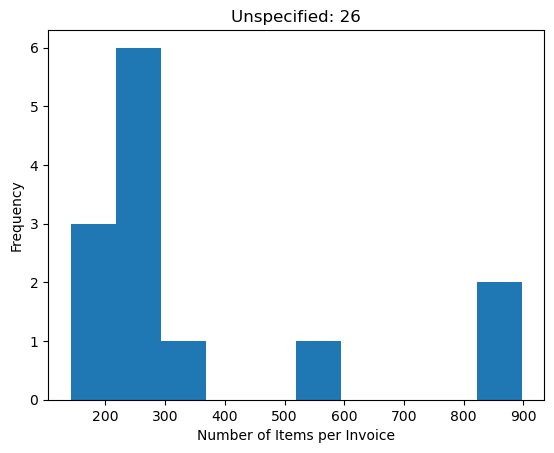

In [73]:
for index, country in enumerate(sorted(df['Country'].unique())):
    df2 = (df[df['Country'] == country])
    df2 = df2[['InvoiceNo', 'StockCode']].groupby('InvoiceNo').agg({'StockCode': lambda x: (list(str(x)))})
    df2['Count'] = df2['StockCode'].apply(lambda x: len(x))
    df2['Count'].plot(kind='hist')
    plt.title(f'{country}: {df2.size}')
    plt.xlabel('Number of Items per Invoice')
    plt.show()

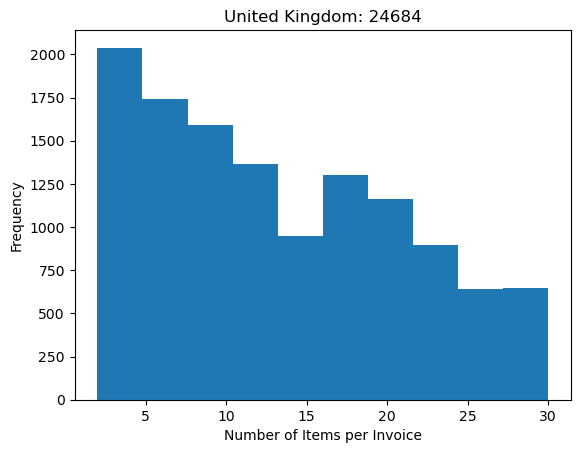

In [7]:
df2 = (df[df['Country'] == 'United Kingdom'])
df2 = df2[['InvoiceNo', 'StockCode']].groupby('InvoiceNo').agg({'StockCode': lambda x: (list(x))})
df2['Count'] = df2['StockCode'].apply(lambda x: len(x))
df2.drop(df2[df2.Count < 2].index, inplace=True)
df2.drop(df2[df2.Count > 30].index, inplace=True)

df2['Count'].plot(kind='hist')
plt.title(f'United Kingdom: {df2.size}')
plt.xlabel('Number of Items per Invoice')
plt.show()


In [8]:
tk = Tokenizer()
tk.fit_on_texts(df.StockCode.unique())
df2['Tokens'] = df2.StockCode.apply(lambda x: list(filter(None, tk.texts_to_sequences(x))))
df2['Tokens'] = df2['Tokens'].apply(lambda x: [item for sublist in x for item in sublist])
df2['Features'] = df2.Tokens.apply(lambda x: x[:-1])
df2['Features'] = df2.Features.apply(lambda x: ((30-len(x)) * [0] + x)[:])
df2['Target'] = df2.Tokens.apply(lambda x: x[1:])
df2['Target'] = df2.Target.apply(lambda x: ((30-len(x)) * [0] + x)[:])
df2.head()

,StockCode,Count,Tokens,Features,Target
InvoiceNo,,,,,
536365,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",7,"[3, 115, 116, 117, 118, 119, 120]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
536366,"[22633, 22632]",2,"[121, 122]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
536367,"[84879, 22745, 22748, 22749, 22310, 84969, 226...",12,"[123, 124, 125, 126, 127, 128, 129, 130, 131, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
536368,"[22960, 22913, 22912, 22914]",4,"[135, 136, 137, 138]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
536372,"[22632, 22633]",2,"[122, 121]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [93]:
product_list_size = df.StockCode.unique().size
maxlen_orders = 30
# Sequential Model
model = Sequential()
# embedding layer
model.add(Embedding(product_list_size, 256, input_length = maxlen_orders, mask_zero = True))
# encoder
model.add(LSTM(256))
# decoder
# repeatvector repeats the input for the desired number of times to change
# 2D-array to 3D array. For example: (1,256) to (1,23,256)
model.add(RepeatVector(maxlen_orders))
model.add(LSTM(256, return_sequences= True ))
model.add(TimeDistributed(Dense(product_list_size, activation ='softmax')))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 256)           1038848   
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 30, 256)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 30, 256)           525312    
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 4058)         1042906   
 tributed)                                                       
                                                                 
Total params: 3,132,378
Trainable params: 3,132,378
No

In [94]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df2.Features, df2.Target, test_size = 0.1)

def fixdim(input):
    size = input.size
    input = np.concatenate(input).ravel()
    input = np.reshape(input, (size,30, 1))
    return input

x_train = fixdim(x_train)
x_test = fixdim(x_test)
y_train = fixdim(y_train)
y_test = fixdim(y_test)

In [ ]:
model.fit(x_train, y_train, batch_size=512, epochs=10)

In [6]:
import pandas as pd
df = pd.read_csv('Raw Database.csv')

In [14]:
!pip install fastparquet
!pip install pyarrow

/usr/bin/zsh: /home/kwaynas/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
/usr/bin/zsh: /home/kwaynas/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 3.5 MB/s eta 0:00:00m eta 0:00:010:00:01


In [15]:
df.to_parquet('df.parquet')
df.to_feather('df.feather')

In [10]:
%timeit df = pd.read_csv('Raw Database.csv')

631 ms ± 139 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit df = pd.read_parquet('df.parquet', columns=['InvoiceNo', 'StockCode', 'Description', 'Country'])

97.6 ms ± 3.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%timeit df = pd.read_feather('df.feather')

104 ms ± 910 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


,InvoiceNo,StockCode,Description,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom
